In [495]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import seaborn as sn

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

from sklearn.cluster import DBSCAN
from sklearn import metrics

### I have used Berka dataset which is a real world financial dataset for a Czech bank http://lisp.vse.cz/pkdd99/Challenge/chall.htm

### Data contains over 1M transactions over 5 years for over 5K customers but we will use only one year of transactions.

### This is an unlabeled data so we do not know how many segements could customers be categorized. Further, we may not get clearly divided clusters but this will give us an insight into different ways and numbers that customers could be segmented. 

## Load the datasets 

In [46]:
# This is the master data table for accounts. We don't need to translate frequency column as this refers to statement
# frequency which we won't be using
df_account = pd.read_table('data_berka/account.txt', sep=';')
df_account.head()

,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,930101
1,3818,74,POPLATEK MESICNE,930101
2,704,55,POPLATEK MESICNE,930101
3,2378,16,POPLATEK MESICNE,930101
4,2632,24,POPLATEK MESICNE,930102


In [47]:
df_card = pd.read_table('data_berka/card.txt', sep=';')
df_card.head()

,card_id,disp_id,type,issued
0,1005,9285,classic,931107 00:00:00
1,104,588,classic,940119 00:00:00
2,747,4915,classic,940205 00:00:00
3,70,439,classic,940208 00:00:00
4,577,3687,classic,940215 00:00:00


In [48]:
## Master data table for clients
df_client = pd.read_table('data_berka/client.txt', sep=';')
df_client.head()

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


### birth_number column is in the format YYMMDD for man and YYMM+50DD for women. Extract age and gender from this column

In [49]:
# extract age as in 1999
def age(row):
    return (99 - int(str(row['birth_number'])[:2]))

df_client['age'] = df_client.apply(age,axis=1)

df_client['age'] = df_client.apply(age,axis=1)

# extract gender
def gender(row):
    if int(str(row['birth_number'])[2:-2]) > 12:
        return 0
    else:
        return 1

df_client['male'] = df_client.apply(gender,axis=1)

# create bins for age group
def modif(row):
    if row['age'] <= 18:
        return 1
    elif (row['age'] > 18) & (row['age'] <= 25):
        return 2 
    elif (row['age'] > 25) & (row['age'] <= 35):
        return 3 
    elif (row['age'] > 35) & (row['age'] <= 45):
        return 4 
    elif (row['age'] > 45) & (row['age'] <= 55):
        return 5 
    elif (row['age'] > 55) & (row['age'] <= 65):
        return 6     
    elif (row['age'] > 65) & (row['age'] <= 75):
        return 7   
    else:
        return 8
    
df_client['age_group'] = df_client.apply(modif, axis = 1)
df_client.head()

,client_id,birth_number,district_id,age,male,age_group
0,1,706213,18,29,0,3
1,2,450204,1,54,1,5
2,3,406009,1,59,0,6
3,4,561201,5,43,1,4
4,5,605703,5,39,0,4


In [50]:
df_disp = pd.read_table('data_berka/disp.txt', sep=';')
df_disp.head()

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


### Disponent seems to be co-owner or joint account holder. Let's just take OWNER records. 

In [51]:
df_disp = df_disp[df_disp.type=='OWNER'].copy()
df_disp.head()

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
3,4,4,3,OWNER
5,6,6,4,OWNER
6,7,7,5,OWNER


### Master data table for districts. 
item	meaning	
A1 = district_id -	district code	
A2 -                district name	
A3 -	                region	
A4 -	                no. of inhabitants	
A5 -	                no. of municipalities with inhabitants < 499	
A6 -	                no. of municipalities with inhabitants 500-1999	
A7 -	                no. of municipalities with inhabitants 2000-9999	
A8 -	                no. of municipalities with inhabitants >10000	
A9 -	                no. of cities	
A10 -	                ratio of urban inhabitants	
A11 -	                average salary	
A12 -	                unemploymant rate '95	
A13 -	                unemploymant rate '96	
A14 -	                no. of enterpreneurs per 1000 inhabitants	
A15 -	                no. of commited crimes '95	
A16 -	                no. of commited crimes '96

Column A4, A10 and A11 might be useful for us.

In [52]:
df_district = pd.read_table('data_berka/district.txt', sep=';')
df_district.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [53]:
df_loan = pd.read_table('data_berka/loan.txt', sep=';')
df_loan.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033.0,B
1,5316,1801,930711,165960,36,4610.0,A
2,6863,9188,930728,127080,60,2118.0,A
3,5325,1843,930803,105804,36,2939.0,A
4,7240,11013,930906,274740,60,4579.0,A


In [54]:
df_order = pd.read_table('data_berka/order.txt', sep=';')
df_order.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER
2,29403,2,QR,13943797,7266.0,SIPO
3,29404,3,WX,83084338,1135.0,SIPO
4,29405,3,CD,24485939,327.0,


### Translate k_symbol column

In [55]:
df_order['k_symbol'] = df_order['k_symbol'].replace(['SIPO'],'HOUSEHOLD')
df_order['k_symbol'] = df_order['k_symbol'].replace(['POJISTNE'],'INSURANCE')
df_order['k_symbol'] = df_order['k_symbol'].replace(['UVER'],'LOAN')
df_order['k_symbol'] = df_order['k_symbol'].replace([" "],'OTHER')
df_order.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,HOUSEHOLD
1,29402,2,ST,89597016,3372.7,LOAN
2,29403,2,QR,13943797,7266.0,HOUSEHOLD
3,29404,3,WX,83084338,1135.0,HOUSEHOLD
4,29405,3,CD,24485939,327.0,OTHER


### Create a pivot table for external remittance

In [56]:
df_order_tmp = pd.DataFrame(df_order.groupby(['account_id','k_symbol']).amount.sum()).reset_index()
df_order_pivot = df_order_tmp.pivot(index='account_id', columns='k_symbol', values='amount').reset_index()
df_order_pivot.head()

k_symbol,account_id,HOUSEHOLD,INSURANCE,LEASING,LOAN,OTHER
0,1,2452.0,NaN,NaN,NaN,NaN
1,2,7266.0,NaN,NaN,3372.7,NaN
2,3,1135.0,3539.0,NaN,NaN,327.0
3,4,3363.0,NaN,NaN,NaN,NaN
4,5,2668.0,NaN,NaN,NaN,NaN


In [57]:
df_trans = pd.read_table('data_berka/trans.txt', sep=';')
df_trans.head()

/Users/u606941/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN


### Let us take only last one year of transactions which is 1998 for this dataset. Translate for clarity and format the transaction date correctly.

In [58]:
df_trans = df_trans[df_trans['date'] >= 980000].copy()

df_trans['k_symbol'] = df_trans['k_symbol'].replace(['SIPO'],'HOUSEHOLD')
df_trans['k_symbol'] = df_trans['k_symbol'].replace(['POJISTNE'],'INSURANCE')
df_trans['k_symbol'] = df_trans['k_symbol'].replace(['UVER'],'LOAN')
df_trans['k_symbol'] = df_trans['k_symbol'].replace(['SLUZBY'],'STATEMENT FEE')
df_trans['k_symbol'] = df_trans['k_symbol'].replace(['UROK'],'INTEREST')
df_trans['k_symbol'] = df_trans['k_symbol'].replace(['SANKC. UROK'],'SANCT. INT. NEG. BAL.')
df_trans['k_symbol'] = df_trans['k_symbol'].replace(['DUCHOD'],'PENSION')

df_trans['type'] = df_trans['type'].replace(['PRIJEM'],'CREDIT')
df_trans['type'] = df_trans['type'].replace(['VYDAJ'],'DEBIT')

df_trans['operation'] = df_trans['operation'].replace(['VYBER KARTOU'],'CC WITHDRAWAL')
df_trans['operation'] = df_trans['operation'].replace(['VKLAD'],'CREDIT IN CASH')
df_trans['operation'] = df_trans['operation'].replace(['PREVOD Z UCTU'],'INTEREST')
df_trans['operation'] = df_trans['operation'].replace(['VYBER'],'WITHDRAWAL')
df_trans['operation'] = df_trans['operation'].replace(['PREVOD NA UCET'],'REMITTANCE EXT')

def dt(row):
    return pd.to_datetime(str(19) + str(row['date']), format='%Y%m%d', errors='ignore')

df_trans['date'] = df_trans.apply(dt,axis=1)


df_trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
734043,733597,2507,1998-01-01,DEBIT,WITHDRAWAL,1300.0,30951.4,NaN,NaN,NaN
734044,799525,2726,1998-01-01,DEBIT,WITHDRAWAL,2760.0,79264.4,NaN,NaN,NaN
734045,799963,2728,1998-01-01,DEBIT,WITHDRAWAL,3200.0,62735.6,NaN,NaN,0.0
734046,801636,2733,1998-01-01,DEBIT,WITHDRAWAL,390.0,35140.8,NaN,NaN,NaN
734047,799151,2724,1998-01-01,DEBIT,WITHDRAWAL,8700.0,41905.2,NaN,NaN,NaN


## Prepare data for clustering

### Create a dataframe for average balance and number of transactions by account id

In [59]:
df_summ = pd.DataFrame(df_trans.groupby(['account_id']).balance.mean().reset_index())
frequency_map = df_trans['account_id'].value_counts().to_dict()
df_summ['freq'] = df_summ.account_id.map(frequency_map)
df_summ.head()

,account_id,balance,freq
0,1,15097.550000,62
1,2,40611.376471,85
2,3,28028.019565,92
3,4,22460.163768,69
4,5,25866.243939,66


In [60]:
# we will get the payments from 'order' table
df_temp1 = pd.merge(df_summ,df_loan[['account_id','amount','duration','status']],'left',on='account_id')
df_temp1.head()

,account_id,balance,freq,amount,duration,status
0,1,15097.550000,62,NaN,NaN,NaN
1,2,40611.376471,85,80952.0,24.0,A
2,3,28028.019565,92,NaN,NaN,NaN
3,4,22460.163768,69,NaN,NaN,NaN
4,5,25866.243939,66,NaN,NaN,NaN


In [61]:
df_temp2 = pd.merge(df_temp1,df_disp[['account_id','disp_id','client_id']],'left',on='account_id')
df_temp2.head()

,account_id,balance,freq,amount,duration,status,disp_id,client_id
0,1,15097.550000,62,NaN,NaN,NaN,1,1
1,2,40611.376471,85,80952.0,24.0,A,2,2
2,3,28028.019565,92,NaN,NaN,NaN,4,4
3,4,22460.163768,69,NaN,NaN,NaN,6,6
4,5,25866.243939,66,NaN,NaN,NaN,7,7


In [62]:
df_temp3 = pd.merge(df_temp2,df_card[['disp_id','type']],'left',on='disp_id')
df_temp3.head()

,account_id,balance,freq,amount,duration,status,disp_id,client_id,type
0,1,15097.550000,62,NaN,NaN,NaN,1,1,NaN
1,2,40611.376471,85,80952.0,24.0,A,2,2,NaN
2,3,28028.019565,92,NaN,NaN,NaN,4,4,NaN
3,4,22460.163768,69,NaN,NaN,NaN,6,6,NaN
4,5,25866.243939,66,NaN,NaN,NaN,7,7,NaN


In [63]:
df_temp4 = pd.merge(df_temp3,df_client[['client_id','district_id','age_group','male']],'left',on='client_id')
df_temp4.head()

,account_id,balance,freq,amount,duration,status,disp_id,client_id,type,district_id,age_group,male
0,1,15097.550000,62,NaN,NaN,NaN,1,1,NaN,18,3,0
1,2,40611.376471,85,80952.0,24.0,A,2,2,NaN,1,5,1
2,3,28028.019565,92,NaN,NaN,NaN,4,4,NaN,5,4,1
3,4,22460.163768,69,NaN,NaN,NaN,6,6,NaN,12,8,1
4,5,25866.243939,66,NaN,NaN,NaN,7,7,NaN,15,7,1


In [64]:
df_temp5 = pd.merge(df_temp4,df_order_pivot,'left',on='account_id')
df_temp5.head()

,account_id,balance,freq,amount,duration,status,disp_id,client_id,type,district_id,age_group,male,HOUSEHOLD,INSURANCE,LEASING,LOAN,OTHER
0,1,15097.550000,62,NaN,NaN,NaN,1,1,NaN,18,3,0,2452.0,NaN,NaN,NaN,NaN
1,2,40611.376471,85,80952.0,24.0,A,2,2,NaN,1,5,1,7266.0,NaN,NaN,3372.7,NaN
2,3,28028.019565,92,NaN,NaN,NaN,4,4,NaN,5,4,1,1135.0,3539.0,NaN,NaN,327.0
3,4,22460.163768,69,NaN,NaN,NaN,6,6,NaN,12,8,1,3363.0,NaN,NaN,NaN,NaN
4,5,25866.243939,66,NaN,NaN,NaN,7,7,NaN,15,7,1,2668.0,NaN,NaN,NaN,NaN


In [75]:
df_final = pd.merge(df_temp5,df_district[['A1','A4','A10','A11']],'left',left_on='district_id',right_on='A1')
df_final.head()

,account_id,balance,freq,amount,duration,status,disp_id,client_id,type,district_id,...,male,HOUSEHOLD,INSURANCE,LEASING,LOAN,OTHER,A1,A4,A10,A11
0,1,15097.550000,62,NaN,NaN,NaN,1,1,NaN,18,...,0,2452.0,NaN,NaN,NaN,NaN,18,70699,65.3,8968
1,2,40611.376471,85,80952.0,24.0,A,2,2,NaN,1,...,1,7266.0,NaN,NaN,3372.7,NaN,1,1204953,100.0,12541
2,3,28028.019565,92,NaN,NaN,NaN,4,4,NaN,5,...,1,1135.0,3539.0,NaN,NaN,327.0,5,95616,51.4,9307
3,4,22460.163768,69,NaN,NaN,NaN,6,6,NaN,12,...,1,3363.0,NaN,NaN,NaN,NaN,12,107870,58.0,8754
4,5,25866.243939,66,NaN,NaN,NaN,7,7,NaN,15,...,1,2668.0,NaN,NaN,NaN,NaN,15,58796,51.9,9045


In [76]:
status_map = {'A': 1, 'B': 2, 'C': 3, 'D':4}
df_final['status'] = df_final['status'].map(status_map)

card_map = {'junior': 1, 'classic': 2, 'gold': 3}
df_final['type'] = df_final['type'].map(card_map)

df_final.drop(['account_id','district_id','disp_id','client_id','A1'], axis = 1, inplace = True)
df_final = df_final.fillna(0).copy()

df_final.columns = ['avg_bal','no_of_trans','loan_amt','loan_duration','loan_status','card_type', 'age_group','male', \
                    'household','insurance','leasing','loan','other','dist_popu','dist_urban_%','dist_avg_salary']
df_final.head()

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary
0,15097.550000,62,0.0,0.0,0.0,0.0,3,0,2452.0,0.0,0.0,0.0,0.0,70699,65.3,8968
1,40611.376471,85,80952.0,24.0,1.0,0.0,5,1,7266.0,0.0,0.0,3372.7,0.0,1204953,100.0,12541
2,28028.019565,92,0.0,0.0,0.0,0.0,4,1,1135.0,3539.0,0.0,0.0,327.0,95616,51.4,9307
3,22460.163768,69,0.0,0.0,0.0,0.0,8,1,3363.0,0.0,0.0,0.0,0.0,107870,58.0,8754
4,25866.243939,66,0.0,0.0,0.0,0.0,7,1,2668.0,0.0,0.0,0.0,0.0,58796,51.9,9045


### get summary statistics on our columns which will help in our cluster analysis

In [77]:
df_final.describe()

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary
count,4492.000000,4492.000000,4492.000000,4492.000000,4492.000000,4492.000000,4492.000000,4492.000000,4492.000000,4492.000000,4492.000000,4492.000000,4492.000000,4.492000e+03,4492.000000,4492.000000
mean,38964.436884,71.744657,22987.920748,5.540516,0.368210,0.384461,4.461932,0.510018,3108.953028,152.922306,169.084394,675.686665,619.309439,2.675448e+05,69.212823,9509.617988
std,19674.492620,18.275424,70013.206977,14.688115,0.951388,0.804828,1.767522,0.499955,3034.266576,734.735722,673.688214,1788.946192,1532.551144,3.569677e+05,19.828906,1324.867648
min,-27796.757692,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.282100e+04,33.900000,8110.000000
25%,22820.621217,61.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.888400e+04,52.700000,8546.750000
50%,35286.760877,70.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,2471.500000,0.000000,0.000000,0.000000,0.000000,1.219470e+05,63.100000,8980.000000
75%,52121.744414,82.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,4613.250000,0.000000,0.000000,0.000000,134.000000,2.261220e+05,85.600000,9897.000000
max,106379.560870,155.000000,590820.000000,60.000000,4.000000,3.000000,8.000000,1.000000,14882.000000,12504.000000,4975.200000,9910.000000,12925.000000,1.204953e+06,100.000000,12541.000000


### Standardize features

In [78]:
sc = StandardScaler()
sc.fit(df_final)
df_std = sc.transform(df_final)

## Use elbow method to find optimal number of clusters

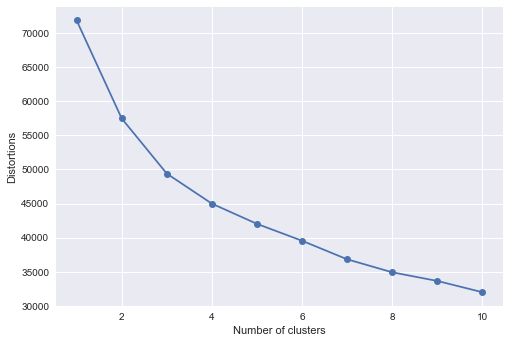

In [79]:
distortions = []
for i in range(1,11):
    km = KMeans(n_clusters=i,
               init = 'k-means++',
               n_init=10,
               max_iter = 300,
               random_state=None)
    km.fit_predict(df_std)
    distortions.append(km.inertia_)
    
plt.plot(range(1,11), distortions, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortions')
plt.show()

### There is no clear elbow but maybe 3-4 clusters would make sense.. Let's see if silhouettes could give us a better sense.

For n_clusters = 2 The average silhouette_score is : 0.363056969129


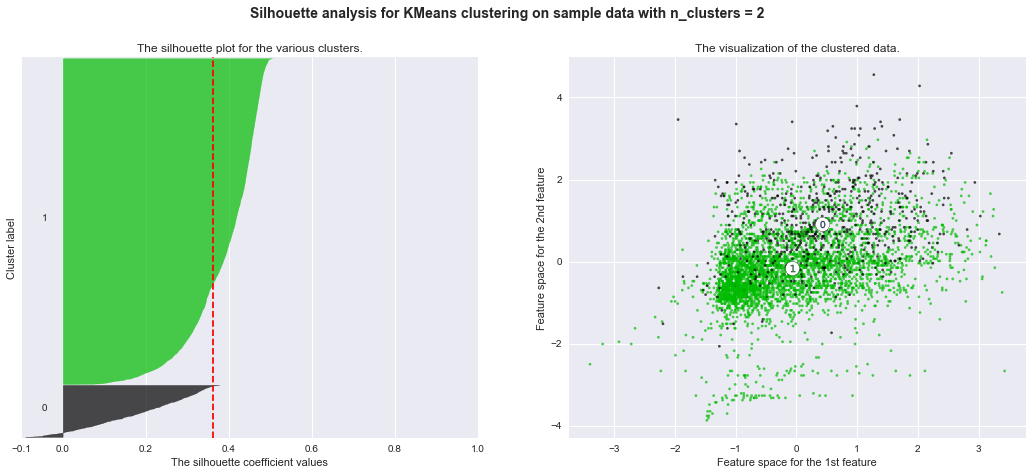

For n_clusters = 3 The average silhouette_score is : 0.305628764033


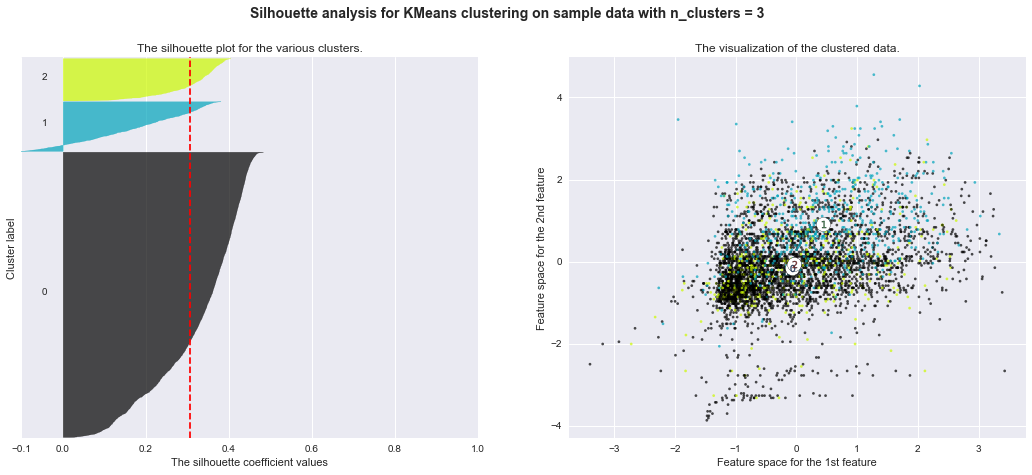

For n_clusters = 4 The average silhouette_score is : 0.201947997895


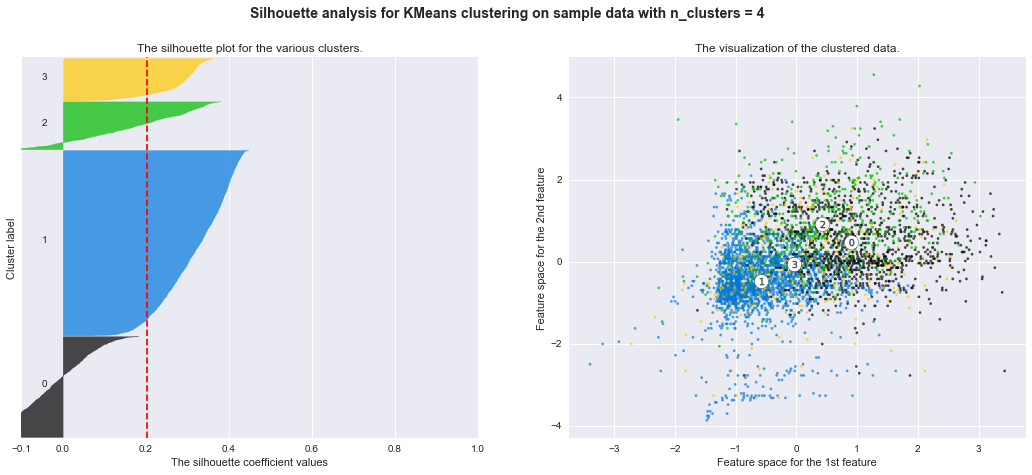

For n_clusters = 5 The average silhouette_score is : 0.210024616733


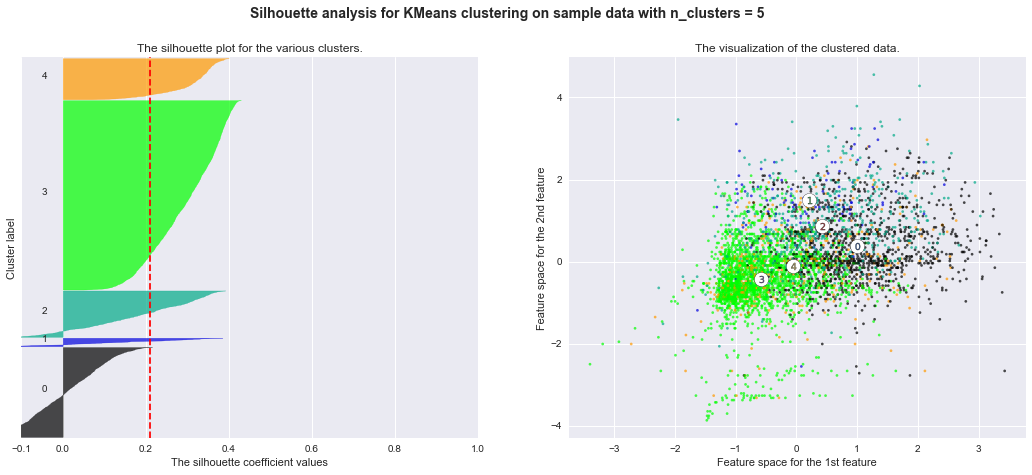

For n_clusters = 6 The average silhouette_score is : 0.208516695396


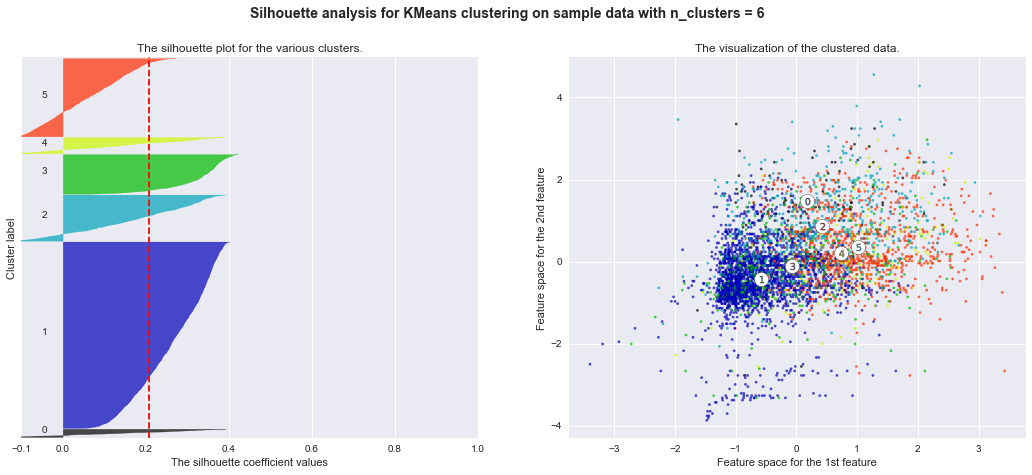

In [109]:
range_n_clusters = [2,3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_std) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init = 'k-means++',n_init=10, max_iter = 300,random_state=10)
    cluster_labels = clusterer.fit_predict(df_std)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_std, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_std, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df_std[:, 0], df_std[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

### As per the Silhouettes above, 2 clusters have the highest score which is 0.36 (which is not great) followed by 3 clusters. I took a run with 2 clusters but algorithm just created one cluster with customers who have loans and other who do not. If I drop loan data and rerun silhouettes I still get 2 optimal clusters but now algorithm creates one cluster for all customers living in 'Hl.m. Praha' district and second cluster for the others.

### Since above 2 clusters will not be helpful, we will run with 4 clusters. We should keep in mind that we will not get clear clusters and that they will be fuzzy. If time permits we can try fuzzy clustering at some point.

In [102]:
km_4 = KMeans(n_clusters=4,
            init = 'k-means++',
            n_init=10,
            max_iter = 300,
            tol=1e-04,
            random_state=10)
y_km_4 = km_4.fit_predict(df_std)

clustered_4 = pd.DataFrame(np.c_[df_final,y_km_4],columns=['avg_bal','no_of_trans','loan_amt','loan_duration', \
                                                           'loan_status', 'card_type', 'age_group','male', \
                                                           'household','insurance', 'leasing','loan','other',\
                                                           'dist_popu','dist_urban_%','dist_avg_salary', \
                                                           'assigned_cluster'])

## Analyze clusters

In [103]:
clustered_4[clustered_4['assigned_cluster']==0].head(10)

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
2,28028.019565,92.0,0.0,0.0,0.0,0.0,4.0,1.0,1135.0,3539.0,0.0,0.0,327.0,95616.0,51.4,9307.0,0.0
6,70656.414286,70.0,0.0,0.0,0.0,3.0,6.0,1.0,4880.0,0.0,0.0,0.0,0.0,110643.0,51.9,8441.0,0.0
7,45820.668235,85.0,0.0,0.0,0.0,0.0,6.0,1.0,2612.0,0.0,0.0,0.0,6712.0,161954.0,48.0,8720.0,0.0
9,52837.660274,73.0,0.0,0.0,0.0,0.0,2.0,0.0,7033.0,0.0,1344.0,0.0,0.0,387570.0,100.0,9897.0,0.0
13,41516.869697,66.0,0.0,0.0,0.0,2.0,6.0,1.0,3629.0,0.0,0.0,0.0,0.0,162580.0,72.8,9538.0,0.0
22,67304.152239,67.0,0.0,0.0,0.0,0.0,5.0,0.0,5807.0,0.0,0.0,0.0,0.0,94812.0,81.8,9650.0,0.0
24,47630.284615,104.0,30276.0,12.0,1.0,0.0,4.0,1.0,6817.0,164.0,0.0,2523.2,1110.0,228848.0,57.2,9893.0,0.0
27,29758.519588,97.0,0.0,0.0,0.0,0.0,2.0,0.0,6871.0,8.0,0.0,0.0,829.0,94725.0,63.4,9920.0,0.0
28,59262.663235,68.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2480.2,0.0,0.0,159617.0,85.2,9198.0,0.0
31,94011.867188,64.0,0.0,0.0,0.0,3.0,3.0,1.0,3892.0,0.0,0.0,0.0,0.0,58400.0,52.4,8620.0,0.0


### First cluster above seems to be for customers who have average to moderately high number of transactions and average balance. Very few of these customers have taken a loan and few have credit cards. Some have credit cards and insurance. 

In [104]:
clustered_4[clustered_4['assigned_cluster']==1].head(10)

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
0,15097.550000,62.0,0.0,0.0,0.0,0.0,3.0,0.0,2452.0,0.0,0.0,0.0,0.0,70699.0,65.3,8968.0,1.0
3,22460.163768,69.0,0.0,0.0,0.0,0.0,8.0,1.0,3363.0,0.0,0.0,0.0,0.0,107870.0,58.0,8754.0,1.0
4,25866.243939,66.0,0.0,0.0,0.0,0.0,7.0,1.0,2668.0,0.0,0.0,0.0,0.0,58796.0,51.9,9045.0,1.0
5,42005.927869,61.0,0.0,0.0,0.0,0.0,6.0,0.0,3954.0,0.0,0.0,0.0,0.0,121947.0,70.5,8541.0,1.0
8,22157.141071,56.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,128118.0,85.3,9317.0,1.0
10,29564.429851,67.0,0.0,0.0,0.0,0.0,6.0,0.0,2132.0,0.0,0.0,0.0,0.0,127369.0,51.2,8369.0,1.0
11,18802.544444,72.0,0.0,0.0,0.0,0.0,8.0,0.0,3592.0,0.0,0.0,0.0,0.0,103347.0,67.0,9104.0,1.0
12,14781.736364,66.0,0.0,0.0,0.0,0.0,6.0,1.0,2444.0,0.0,0.0,0.0,0.0,127369.0,51.2,8369.0,1.0
14,29817.052857,70.0,0.0,0.0,0.0,0.0,2.0,1.0,3072.0,0.0,0.0,0.0,0.0,112709.0,73.5,8369.0,1.0
15,29426.240000,50.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,107870.0,58.0,8754.0,1.0


### Second cluster above seems to be for customers with low to average number of transactions and low balance, do not have credit card or a loan. Also, very few of these customers have insurance or lease.

In [105]:
clustered_4[clustered_4['assigned_cluster']==2].head(10)

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
35,32933.232673,101.0,318480.0,60.0,4.0,0.0,5.0,1.0,2317.0,97.0,0.0,5307.5,2584.0,70646.0,58.4,8547.0,2.0
36,33742.440541,111.0,110736.0,48.0,3.0,0.0,6.0,0.0,6901.0,228.0,0.0,2306.8,231.0,51428.0,52.7,8402.0,2.0
63,80306.553191,94.0,165960.0,24.0,1.0,0.0,5.0,0.0,6393.0,0.0,0.0,6915.0,445.0,93931.0,56.9,8427.0,2.0
89,45571.641818,110.0,102876.0,12.0,1.0,2.0,6.0,1.0,1436.0,3.0,0.0,8573.0,2426.0,323870.0,100.0,10673.0,2.0
95,51859.047917,96.0,265320.0,36.0,4.0,0.0,3.0,1.0,0.0,0.0,0.0,7370.2,0.0,105606.0,53.0,8254.0,2.0
97,28154.145652,46.0,352704.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,0.0,7348.0,0.0,103347.0,67.0,9104.0,2.0
102,44169.389583,96.0,162576.0,36.0,3.0,2.0,5.0,1.0,3050.0,0.0,0.0,4516.0,98.0,159617.0,85.2,9198.0,2.0
123,46154.458209,67.0,88440.0,12.0,1.0,2.0,5.0,0.0,0.0,0.0,0.0,7370.2,0.0,128118.0,85.3,9317.0,2.0
163,54210.665041,123.0,104808.0,12.0,1.0,0.0,6.0,1.0,6256.0,735.0,0.0,8734.0,1617.0,125832.0,48.3,8512.0,2.0
213,52428.518421,76.0,109344.0,12.0,3.0,2.0,5.0,0.0,8928.0,0.0,0.0,9112.0,0.0,285387.0,89.9,10177.0,2.0


### Third cluster above seems to be for customers who have taken a loan. Some have credit cards, few have insurance or are leasing.

In [106]:
clustered_4[clustered_4['assigned_cluster']==3].head(10)

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
1,40611.376471,85.0,80952.0,24.0,1.0,0.0,5.0,1.0,7266.0,0.0,0.0,3372.7,0.0,1204953.0,100.0,12541.0,3.0
16,57974.411429,35.0,0.0,0.0,0.0,0.0,3.0,0.0,4032.0,0.0,0.0,0.0,0.0,1204953.0,100.0,12541.0,3.0
21,32719.495455,66.0,0.0,0.0,0.0,0.0,5.0,1.0,6352.0,0.0,0.0,0.0,0.0,1204953.0,100.0,12541.0,3.0
46,14446.753333,60.0,0.0,0.0,0.0,0.0,7.0,0.0,3102.0,0.0,0.0,0.0,0.0,1204953.0,100.0,12541.0,3.0
47,52562.639506,81.0,0.0,0.0,0.0,0.0,4.0,1.0,269.0,0.0,0.0,0.0,7024.0,1204953.0,100.0,12541.0,3.0
54,48520.884932,73.0,0.0,0.0,0.0,0.0,5.0,0.0,4107.0,0.0,0.0,0.0,0.0,1204953.0,100.0,12541.0,3.0
62,60666.950000,60.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,4471.3,0.0,0.0,1204953.0,100.0,12541.0,3.0
67,64092.203704,108.0,0.0,0.0,0.0,1.0,2.0,0.0,968.0,1011.0,0.0,0.0,2380.0,1204953.0,100.0,12541.0,3.0
68,49743.302381,84.0,0.0,0.0,0.0,0.0,4.0,1.0,7109.0,0.0,2923.0,0.0,2286.0,1204953.0,100.0,12541.0,3.0
70,25204.498462,65.0,0.0,0.0,0.0,0.0,5.0,0.0,3369.0,0.0,0.0,0.0,0.0,1204953.0,100.0,12541.0,3.0


### Final cluster above seems to be for customers from Hl.m. Praha disrict which has the highest population and 100% urban ratio. Most of these customer have not taken loan but some have credit cards.

 ## Next, we will try Hierarchical clustering.

In [230]:
# generate the linkage matrix
Z = linkage(df_std, 'single','euclidean')

### Cophenetic Correlation Coefficient. The closer it is to 1, the better

In [231]:
c, coph_dists = cophenet(Z, pdist(df_std))
c

0.72589685148970429

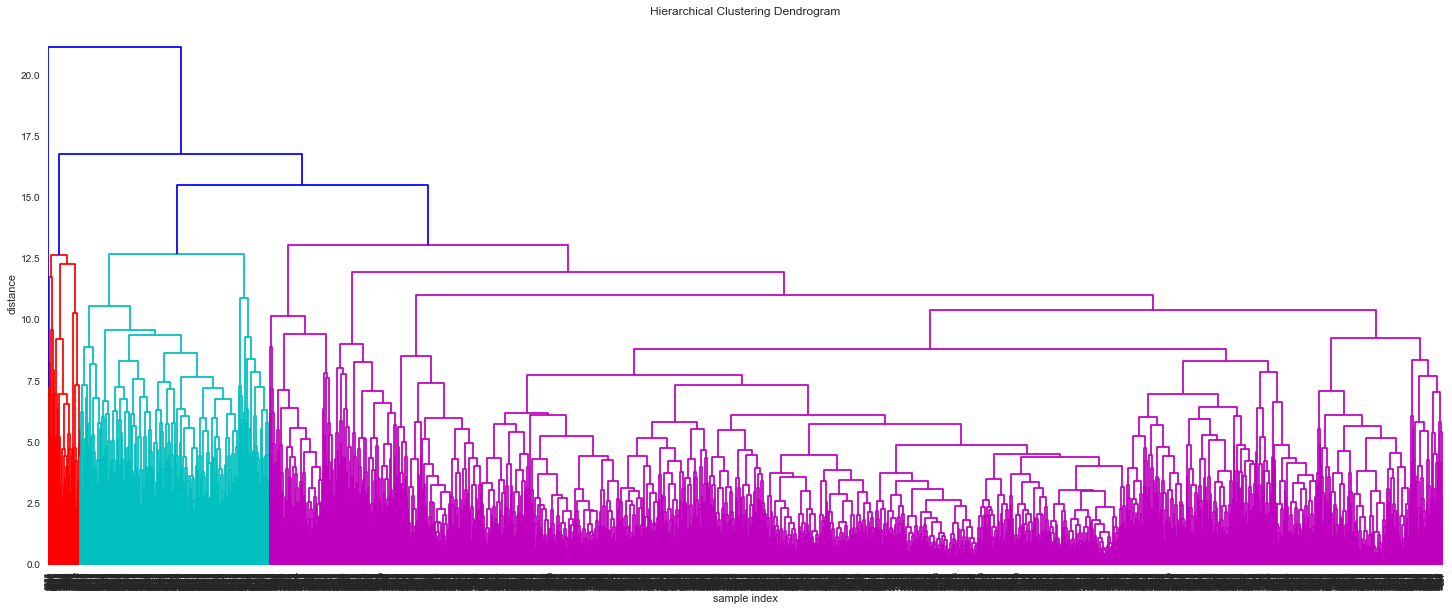

In [212]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

### Truncate dendrogram for last 20 merges

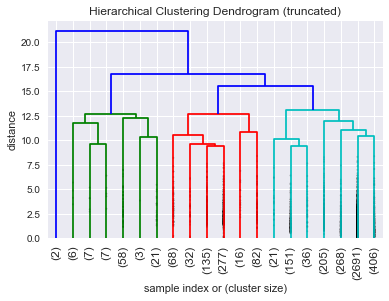

In [213]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

### Although logical cut seems to be at 15 which gives us 4 clusters but let's cut it just over 12.5 which gives us 5 clusters.

In [214]:
hclust_5 = fcluster(Z, 5, criterion='maxclust')
clustered_5 = pd.DataFrame(np.c_[df_final,hclust_5],columns=['avg_bal','no_of_trans','loan_amt','loan_duration', \
                                                           'loan_status', 'card_type', 'age_group','male', \
                                                           'household','insurance', 'leasing','loan','other', \
                                                           'dist_popu','dist_urban_%','dist_avg_salary', \
                                                           'assigned_cluster'])
clustered_5.head()

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
0,15097.550000,62.0,0.0,0.0,0.0,0.0,3.0,0.0,2452.0,0.0,0.0,0.0,0.0,70699.0,65.3,8968.0,5.0
1,40611.376471,85.0,80952.0,24.0,1.0,0.0,5.0,1.0,7266.0,0.0,0.0,3372.7,0.0,1204953.0,100.0,12541.0,3.0
2,28028.019565,92.0,0.0,0.0,0.0,0.0,4.0,1.0,1135.0,3539.0,0.0,0.0,327.0,95616.0,51.4,9307.0,2.0
3,22460.163768,69.0,0.0,0.0,0.0,0.0,8.0,1.0,3363.0,0.0,0.0,0.0,0.0,107870.0,58.0,8754.0,5.0
4,25866.243939,66.0,0.0,0.0,0.0,0.0,7.0,1.0,2668.0,0.0,0.0,0.0,0.0,58796.0,51.9,9045.0,5.0


### Analyze the clusters

In [215]:
clustered_5[clustered_5['assigned_cluster']==1].head(50)

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
3584,45196.290625,96.0,0.0,0.0,0.0,2.0,4.0,1.0,553.0,10608.0,0.0,0.0,2790.0,81344.0,55.3,8899.0,1.0
4377,47565.943689,103.0,0.0,0.0,0.0,0.0,4.0,1.0,713.0,12504.0,2768.9,0.0,1780.0,1204953.0,100.0,12541.0,1.0


### First cluster above is bit strange as it has only 2 customers with similar average balance, number of transactions. Both are in the same age group, do not have loan but have insurance.

In [217]:
clustered_5[clustered_5['assigned_cluster']==2].head(10)

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
2,28028.019565,92.0,0.0,0.0,0.0,0.0,4.0,1.0,1135.0,3539.0,0.0,0.0,327.0,95616.0,51.4,9307.0,2.0
61,52652.141053,95.0,0.0,0.0,0.0,2.0,3.0,0.0,686.0,3401.0,0.0,0.0,3315.0,159617.0,85.2,9198.0,2.0
84,19945.738235,102.0,0.0,0.0,0.0,0.0,3.0,1.0,2774.0,4372.0,0.0,0.0,2736.0,1204953.0,100.0,12541.0,2.0
132,36292.414444,90.0,0.0,0.0,0.0,0.0,5.0,1.0,3462.0,6716.0,3016.5,0.0,1791.0,85852.0,59.8,8965.0,2.0
185,71204.860194,103.0,0.0,0.0,0.0,2.0,4.0,0.0,1270.0,2554.0,0.0,0.0,4802.0,77963.0,51.5,8546.0,2.0
194,17453.998824,85.0,0.0,0.0,0.0,0.0,2.0,0.0,403.0,2726.0,0.0,0.0,10.0,112065.0,69.4,11277.0,2.0
196,25959.567021,94.0,0.0,0.0,0.0,0.0,3.0,0.0,483.0,1796.0,0.0,0.0,41.0,114006.0,62.3,9065.0,2.0
294,44840.402479,121.0,0.0,0.0,0.0,1.0,2.0,1.0,4777.0,3375.0,0.0,422.0,726.0,102609.0,52.0,8187.0,2.0
385,32025.176667,90.0,0.0,0.0,0.0,2.0,5.0,1.0,9632.0,3579.0,1339.0,0.0,1497.0,157042.0,33.9,8743.0,2.0
461,57232.278505,107.0,0.0,0.0,0.0,0.0,3.0,0.0,7421.0,3572.0,2629.6,0.0,1591.0,138032.0,64.6,8819.0,2.0


### Second cluster above is for customers with average to high number of transactions who have insurance and make household and other payments. Very few have loans or credit cards.

In [219]:
clustered_5[clustered_5['assigned_cluster']==3].head(10)

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
1,40611.376471,85.0,80952.0,24.0,1.0,0.0,5.0,1.0,7266.0,0.0,0.0,3372.7,0.0,1204953.0,100.0,12541.0,3.0
18,10520.829630,81.0,30276.0,12.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,2523.2,0.0,103347.0,67.0,9104.0,3.0
24,47630.284615,104.0,30276.0,12.0,1.0,0.0,4.0,1.0,6817.0,164.0,0.0,2523.2,1110.0,228848.0,57.2,9893.0,3.0
35,32933.232673,101.0,318480.0,60.0,4.0,0.0,5.0,1.0,2317.0,97.0,0.0,5307.5,2584.0,70646.0,58.4,8547.0,3.0
36,33742.440541,111.0,110736.0,48.0,3.0,0.0,6.0,0.0,6901.0,228.0,0.0,2306.8,231.0,51428.0,52.7,8402.0,3.0
63,80306.553191,94.0,165960.0,24.0,1.0,0.0,5.0,0.0,6393.0,0.0,0.0,6915.0,445.0,93931.0,56.9,8427.0,3.0
89,45571.641818,110.0,102876.0,12.0,1.0,2.0,6.0,1.0,1436.0,3.0,0.0,8573.0,2426.0,323870.0,100.0,10673.0,3.0
95,51859.047917,96.0,265320.0,36.0,4.0,0.0,3.0,1.0,0.0,0.0,0.0,7370.2,0.0,105606.0,53.0,8254.0,3.0
97,28154.145652,46.0,352704.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,0.0,7348.0,0.0,103347.0,67.0,9104.0,3.0
102,44169.389583,96.0,162576.0,36.0,3.0,2.0,5.0,1.0,3050.0,0.0,0.0,4516.0,98.0,159617.0,85.2,9198.0,3.0


### Most of the customers in cluster 3 have a loan, have average to high number of transaction and do not have leasing payments.

In [222]:
clustered_5[clustered_5['assigned_cluster']==4].head(10)

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
7,45820.668235,85.0,0.0,0.0,0.0,0.0,6.0,1.0,2612.0,0.0,0.0,0.0,6712.0,161954.0,48.0,8720.0,4.0
23,27540.165152,66.0,0.0,0.0,0.0,0.0,4.0,0.0,221.0,0.0,0.0,0.0,7641.0,323870.0,100.0,10673.0,4.0
32,54303.975309,81.0,0.0,0.0,0.0,2.0,6.0,1.0,502.0,0.0,1479.0,0.0,6070.0,228848.0,57.2,9893.0,4.0
38,24635.688571,70.0,0.0,0.0,0.0,0.0,6.0,1.0,33.0,0.0,0.0,0.0,4301.0,93931.0,56.9,8427.0,4.0
49,33531.319767,86.0,0.0,0.0,0.0,0.0,5.0,0.0,560.0,0.0,0.0,0.0,3723.0,93931.0,56.9,8427.0,4.0
56,62649.370238,84.0,0.0,0.0,0.0,0.0,5.0,1.0,695.0,0.0,0.0,0.0,6190.0,161854.0,76.3,9425.0,4.0
78,23031.775342,73.0,0.0,0.0,0.0,0.0,3.0,0.0,2210.0,0.0,0.0,0.0,3940.0,133777.0,84.7,8705.0,4.0
92,52825.097619,84.0,0.0,0.0,0.0,0.0,2.0,0.0,598.0,0.0,0.0,0.0,7329.0,118650.0,85.6,9832.0,4.0
124,46383.442105,95.0,0.0,0.0,0.0,0.0,6.0,0.0,4943.0,0.0,3094.0,0.0,5123.0,197099.0,74.7,9624.0,4.0
179,35779.074766,107.0,0.0,0.0,0.0,0.0,3.0,0.0,4519.0,42.0,0.0,0.0,4549.0,323870.0,100.0,10673.0,4.0


### Cluster 4 includes customers who do not have loans and who make household payments.

In [225]:
clustered_5[clustered_5['assigned_cluster']==5].head(10)

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
0,15097.550000,62.0,0.0,0.0,0.0,0.0,3.0,0.0,2452.0,0.0,0.0,0.0,0.0,70699.0,65.3,8968.0,5.0
3,22460.163768,69.0,0.0,0.0,0.0,0.0,8.0,1.0,3363.0,0.0,0.0,0.0,0.0,107870.0,58.0,8754.0,5.0
4,25866.243939,66.0,0.0,0.0,0.0,0.0,7.0,1.0,2668.0,0.0,0.0,0.0,0.0,58796.0,51.9,9045.0,5.0
5,42005.927869,61.0,0.0,0.0,0.0,0.0,6.0,0.0,3954.0,0.0,0.0,0.0,0.0,121947.0,70.5,8541.0,5.0
6,70656.414286,70.0,0.0,0.0,0.0,3.0,6.0,1.0,4880.0,0.0,0.0,0.0,0.0,110643.0,51.9,8441.0,5.0
8,22157.141071,56.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,128118.0,85.3,9317.0,5.0
9,52837.660274,73.0,0.0,0.0,0.0,0.0,2.0,0.0,7033.0,0.0,1344.0,0.0,0.0,387570.0,100.0,9897.0,5.0
10,29564.429851,67.0,0.0,0.0,0.0,0.0,6.0,0.0,2132.0,0.0,0.0,0.0,0.0,127369.0,51.2,8369.0,5.0
11,18802.544444,72.0,0.0,0.0,0.0,0.0,8.0,0.0,3592.0,0.0,0.0,0.0,0.0,103347.0,67.0,9104.0,5.0
12,14781.736364,66.0,0.0,0.0,0.0,0.0,6.0,1.0,2444.0,0.0,0.0,0.0,0.0,127369.0,51.2,8369.0,5.0


### Cluster 5 is for customers with low to moderate balance and number of transactions, who do not have a loan and very few have a credit card, insurance or lease.

## Let us try density based clustering

In [482]:
dbsc = DBSCAN(eps = 2, min_samples = 30).fit(df_std)

In [483]:
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_std, labels))

Silhouette Coefficient: 0.072


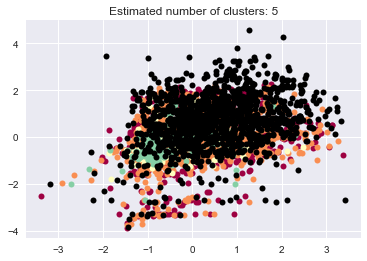

In [484]:
# Number of clusters in labels
n_clusters_ = len(set(labels))


unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = df_std[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = df_std[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [481]:
clustered_dbsc = pd.DataFrame(np.c_[df_final,labels],columns=['avg_bal','no_of_trans','loan_amt','loan_duration', \
                                                           'loan_status', 'card_type', 'age_group','male', \
                                                           'household','insurance', 'leasing','loan','other',\
                                                           'dist_popu','dist_urban_%','dist_avg_salary', \
                                                           'assigned_cluster'])
clustered_dbsc.head()

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
0,15097.550000,62.0,0.0,0.0,0.0,0.0,3.0,0.0,2452.0,0.0,0.0,0.0,0.0,70699.0,65.3,8968.0,0.0
1,40611.376471,85.0,80952.0,24.0,1.0,0.0,5.0,1.0,7266.0,0.0,0.0,3372.7,0.0,1204953.0,100.0,12541.0,-1.0
2,28028.019565,92.0,0.0,0.0,0.0,0.0,4.0,1.0,1135.0,3539.0,0.0,0.0,327.0,95616.0,51.4,9307.0,-1.0
3,22460.163768,69.0,0.0,0.0,0.0,0.0,8.0,1.0,3363.0,0.0,0.0,0.0,0.0,107870.0,58.0,8754.0,1.0
4,25866.243939,66.0,0.0,0.0,0.0,0.0,7.0,1.0,2668.0,0.0,0.0,0.0,0.0,58796.0,51.9,9045.0,1.0


#### Cluster 1

In [492]:
clustered_dbsc[clustered_dbsc['assigned_cluster']==-1].head()

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
1,40611.376471,85.0,80952.0,24.0,1.0,0.0,5.0,1.0,7266.0,0.0,0.0,3372.7,0.0,1204953.0,100.0,12541.0,-1.0
2,28028.019565,92.0,0.0,0.0,0.0,0.0,4.0,1.0,1135.0,3539.0,0.0,0.0,327.0,95616.0,51.4,9307.0,-1.0
9,52837.660274,73.0,0.0,0.0,0.0,0.0,2.0,0.0,7033.0,0.0,1344.0,0.0,0.0,387570.0,100.0,9897.0,-1.0
18,10520.829630,81.0,30276.0,12.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,2523.2,0.0,103347.0,67.0,9104.0,-1.0
23,27540.165152,66.0,0.0,0.0,0.0,0.0,4.0,0.0,221.0,0.0,0.0,0.0,7641.0,323870.0,100.0,10673.0,-1.0


#### Cluster 2

In [494]:
clustered_dbsc[clustered_dbsc['assigned_cluster']==0].head()

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
0,15097.550000,62.0,0.0,0.0,0.0,0.0,3.0,0.0,2452.0,0.0,0.0,0.0,0.0,70699.0,65.3,8968.0,0.0
5,42005.927869,61.0,0.0,0.0,0.0,0.0,6.0,0.0,3954.0,0.0,0.0,0.0,0.0,121947.0,70.5,8541.0,0.0
10,29564.429851,67.0,0.0,0.0,0.0,0.0,6.0,0.0,2132.0,0.0,0.0,0.0,0.0,127369.0,51.2,8369.0,0.0
11,18802.544444,72.0,0.0,0.0,0.0,0.0,8.0,0.0,3592.0,0.0,0.0,0.0,0.0,103347.0,67.0,9104.0,0.0
15,29426.240000,50.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,107870.0,58.0,8754.0,0.0


#### Cluster 3

In [488]:
clustered_dbsc[clustered_dbsc['assigned_cluster']==1].head()

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
3,22460.163768,69.0,0.0,0.0,0.0,0.0,8.0,1.0,3363.0,0.0,0.0,0.0,0.0,107870.0,58.0,8754.0,1.0
4,25866.243939,66.0,0.0,0.0,0.0,0.0,7.0,1.0,2668.0,0.0,0.0,0.0,0.0,58796.0,51.9,9045.0,1.0
6,70656.414286,70.0,0.0,0.0,0.0,3.0,6.0,1.0,4880.0,0.0,0.0,0.0,0.0,110643.0,51.9,8441.0,1.0
7,45820.668235,85.0,0.0,0.0,0.0,0.0,6.0,1.0,2612.0,0.0,0.0,0.0,6712.0,161954.0,48.0,8720.0,1.0
8,22157.141071,56.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,128118.0,85.3,9317.0,1.0


#### Cluster 4

In [489]:
clustered_dbsc[clustered_dbsc['assigned_cluster']==2].head()

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
21,32719.495455,66.0,0.0,0.0,0.0,0.0,5.0,1.0,6352.0,0.0,0.0,0.0,0.0,1204953.0,100.0,12541.0,2.0
166,48162.206122,49.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1204953.0,100.0,12541.0,2.0
192,38004.437097,62.0,0.0,0.0,0.0,0.0,4.0,1.0,4297.0,0.0,0.0,0.0,0.0,1204953.0,100.0,12541.0,2.0
217,40209.742105,95.0,0.0,0.0,0.0,0.0,4.0,1.0,5615.0,1058.0,0.0,0.0,1527.0,1204953.0,100.0,12541.0,2.0
258,29230.960000,70.0,0.0,0.0,0.0,0.0,6.0,1.0,9886.0,0.0,0.0,0.0,0.0,1204953.0,100.0,12541.0,2.0


#### Cluster 5

In [490]:
clustered_dbsc[clustered_dbsc['assigned_cluster']==3].head()

,avg_bal,no_of_trans,loan_amt,loan_duration,loan_status,card_type,age_group,male,household,insurance,leasing,loan,other,dist_popu,dist_urban_%,dist_avg_salary,assigned_cluster
16,57974.411429,35.0,0.0,0.0,0.0,0.0,3.0,0.0,4032.0,0.0,0.0,0.0,0.0,1204953.0,100.0,12541.0,3.0
46,14446.753333,60.0,0.0,0.0,0.0,0.0,7.0,0.0,3102.0,0.0,0.0,0.0,0.0,1204953.0,100.0,12541.0,3.0
54,48520.884932,73.0,0.0,0.0,0.0,0.0,5.0,0.0,4107.0,0.0,0.0,0.0,0.0,1204953.0,100.0,12541.0,3.0
70,25204.498462,65.0,0.0,0.0,0.0,0.0,5.0,0.0,3369.0,0.0,0.0,0.0,0.0,1204953.0,100.0,12541.0,3.0
142,20622.010811,74.0,0.0,0.0,0.0,0.0,2.0,0.0,426.0,0.0,0.0,0.0,2993.0,1204953.0,100.0,12541.0,3.0


### we can analyze the clusters above as previously done with K-means and Hierarchical.